# Accessing LIBERO Dataset Samples

This notebook demonstrates how to access and explore LIBERO dataset samples.

The datasets are stored in HDF5 format. Each dataset contains multiple episodes (demonstrations) with:
- **Observations**: images (camera views), states (robot proprioception)
- **Actions**: 7-DOF robot actions
- **Metadata**: task descriptions, environment info


In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import numpy as np
import os
import json
from pathlib import Path

# Path to downloaded datasets (adjust if you downloaded to a different location)
DATASET_DIR = "/cluster/scratch/anmari/libero_datasets"


## Helper Functions


In [2]:
def list_available_datasets(dataset_dir):
    """List all available LIBERO datasets in the directory."""
    dataset_dir = Path(dataset_dir)
    available = []
    for dataset_name in ["libero_object", "libero_goal", "libero_spatial", "libero_10", "libero_90"]:
        dataset_path = dataset_dir / dataset_name
        if dataset_path.exists():
            hdf5_files = list(dataset_path.glob("*.hdf5"))
            if hdf5_files:
                available.append((dataset_name, len(hdf5_files)))
    return available


In [3]:
def load_episode(dataset_path, episode_id=0):
    """
    Load a specific episode from a LIBERO dataset file.

    Args:
        dataset_path: Path to the HDF5 file
        episode_id: Episode number (0-indexed)

    Returns:
        Dictionary containing observations, actions, and metadata
    """
    with h5py.File(dataset_path, "r") as f:
        # Get all demo keys (LIBERO uses "demo_0", "demo_1", etc.)
        demos = sorted([k for k in f["data"].keys() if k.startswith("demo_")])

        # Sort by episode number
        if demos:
            inds = np.argsort([int(elem[5:]) for elem in demos])
            demos = [demos[i] for i in inds]

        if episode_id >= len(demos):
            raise ValueError(f"Episode {episode_id} not found. Dataset has {len(demos)} episodes.")

        demo_key = demos[episode_id]
        demo_data = f["data"][demo_key]

        # Extract observations
        obs = {}
        if "obs" in demo_data:
            for obs_key in demo_data["obs"].keys():
                obs[obs_key] = np.array(demo_data["obs"][obs_key])

        # Extract actions
        actions = np.array(demo_data["actions"])

        # Extract metadata
        metadata = {}
        for key in demo_data.attrs.keys():
            metadata[key] = demo_data.attrs[key]

        # Get problem info (task description)
        problem_info = json.loads(f["data"].attrs.get("problem_info", "{}"))

        return {
            "observations": obs,
            "actions": actions,
            "metadata": metadata,
            "problem_info": problem_info,
            "episode_length": len(actions)
        }


In [4]:
def explore_dataset(dataset_path):
    """Explore a dataset file and print its structure."""
    with h5py.File(dataset_path, "r") as f:
        print(f"\n=== Dataset: {dataset_path.name} ===")

        # Get problem info
        if "problem_info" in f["data"].attrs:
            problem_info = json.loads(f["data"].attrs["problem_info"])
            language_instruction = "".join(problem_info.get("language_instruction", []))
            print(f"Task: {language_instruction.strip(chr(34))}")

        # Get environment metadata
        if "env_args" in f["data"].attrs:
            env_meta = json.loads(f["data"].attrs["env_args"])
            print(f"Environment: {env_meta.get('env_name', 'N/A')}")

        # List demos (LIBERO uses "demo_0", "demo_1", etc.)
        demos = sorted([k for k in f["data"].keys() if k.startswith("demo_")])
        if demos:
            # Sort by episode number
            inds = np.argsort([int(elem[5:]) for elem in demos])
            demos = [demos[i] for i in inds]

        print(f"\nNumber of episodes: {len(demos)}")

        # Show structure of first episode
        if demos:
            first_demo = f["data"][demos[0]]
            print(f"\nFirst episode structure:")
            print(f"  Demo key: {demos[0]}")
            print(f"  Number of steps: {first_demo.attrs.get('num_samples', 'N/A')}")

            if "obs" in first_demo:
                print(f"  Observations:")
                for obs_key in first_demo["obs"].keys():
                    shape = first_demo["obs"][obs_key].shape
                    print(f"    - {obs_key}: shape {shape}")

            if "actions" in first_demo:
                print(f"  Actions: shape {first_demo['actions'].shape}")


In [5]:
# Check if datasets are downloaded
if not os.path.exists(DATASET_DIR):
    print(f"Dataset directory not found: {DATASET_DIR}")
    print("Please download the datasets first using:")
    print("  ./download_libero_to_scratch.sh")
else:
    print(f"Dataset directory found: {DATASET_DIR}")


Dataset directory found: /cluster/scratch/anmari/libero_datasets


## List available datasets


In [6]:
# List available datasets
print("Available LIBERO datasets:")
available = list_available_datasets(DATASET_DIR)
if not available:
    print("  No datasets found. Please download them first.")
else:
    for dataset_name, num_files in available:
        print(f"  - {dataset_name}: {num_files} files")


Available LIBERO datasets:
  - libero_object: 10 files
  - libero_goal: 10 files
  - libero_spatial: 10 files
  - libero_10: 10 files
  - libero_90: 90 files


## Explore a dataset file

You can use either our custom function or the original LIBERO utility function.


In [7]:
# Example: Explore a specific dataset file using our custom function
if available:
    dataset_name, num_files = available[0]
    dataset_path = Path(DATASET_DIR) / dataset_name

    # Get the first HDF5 file
    hdf5_files = sorted(list(dataset_path.glob("*.hdf5")))
    if hdf5_files:
        print(f"\n{'='*60}")
        print(f"Exploring: {hdf5_files[0].name}")
        explore_dataset(hdf5_files[0])



Exploring: pick_up_the_alphabet_soup_and_place_it_in_the_basket_demo.hdf5

=== Dataset: pick_up_the_alphabet_soup_and_place_it_in_the_basket_demo.hdf5 ===
Task: pick up the alphabet soup and place it in the basket
Environment: Libero_Floor_Manipulation

Number of episodes: 50

First episode structure:
  Demo key: demo_0
  Number of steps: 148
  Observations:
    - agentview_rgb: shape (148, 128, 128, 3)
    - ee_ori: shape (148, 3)
    - ee_pos: shape (148, 3)
    - ee_states: shape (148, 6)
    - eye_in_hand_rgb: shape (148, 128, 128, 3)
    - gripper_states: shape (148, 2)
    - joint_states: shape (148, 7)
  Actions: shape (148, 7)


## Using the original LIBERO utility function

Alternatively, you can use the original LIBERO `get_dataset_info` function which provides more detailed statistics.


In [8]:
import sys
sys.path.insert(0, str(Path("/cluster/home/anmari/meta_vlas/third_party/libero")))
from libero.libero.utils import dataset_utils


# Use the original LIBERO utility function
if available and hdf5_files:

    print(f"\n{'='*60}")
    print("Using original LIBERO get_dataset_info function:")
    print(f"{'='*60}")
    dataset_utils.get_dataset_info(str(hdf5_files[0]), verbose=True)



Using original LIBERO get_dataset_info function:

total transitions: 7808
total trajectories: 50
traj length mean: 156.16
traj length std: 13.72058307798907
traj length min: 136
traj length max: 196
action min: -1.0
action max: 1.0
language instruction: pick up the alphabet soup and place it in the basket

==== Filter Keys ====
no filter keys


==== Env Meta ====
{
    "type": 1,
    "env_name": "Libero_Floor_Manipulation",
    "problem_name": "libero_floor_manipulation",
    "bddl_file": "chiliocosm/bddl_files/libero_object/pick_the_alphabet_soup_and_place_it_in_the_basket.bddl",
    "env_kwargs": {
        "robots": [
            "Panda"
        ],
        "controller_configs": {
            "type": "OSC_POSE",
            "input_max": 1,
            "input_min": -1,
            "output_max": [
                0.05,
                0.05,
                0.05,
                0.5,
                0.5,
                0.5
            ],
            "output_min": [
                -0.0

## Load and examine an episode

Now that we've fixed the functions to use "demo_" keys instead of "episode_", this should work correctly.


## Understanding the Dataset Structure

Let's break down what each component means:


### Dataset Overview

- **Task**: "pick up the alphabet soup and place it in the basket" - This is the language instruction describing what the robot should do
- **Environment**: `Libero_Floor_Manipulation` - The simulation environment used (MuJoCo-based)
- **Number of episodes**: 50 - This file contains 50 demonstration episodes (each showing how to complete the task)
- **Demo key**: `demo_0` - Each episode is labeled as `demo_0`, `demo_1`, etc.

### Complete Episode Structure (148 transitions)

Each episode contains 148 time steps (transitions) showing how an expert human teleoperator completed the task. Below is a complete breakdown of all data fields:

#### Observations (`obs` - what the robot "sees" and "feels"):

1. **`agentview_rgb`** (148, 128, 128, 3)
   - Third-person camera view of the scene
   - RGB images: 128×128 pixels, 3 color channels (R, G, B)
   - Shape: (time_steps, height, width, channels)
   - Provides global view of the workspace and objects

2. **`eye_in_hand_rgb`** (148, 128, 128, 3)
   - First-person camera view from the robot's gripper/wrist
   - Shows what the robot "sees" from its hand perspective
   - Same format as agentview (128×128 RGB)
   - Useful for close-up manipulation tasks

3. **`ee_pos`** (148, 3)
   - End-effector (gripper) position in 3D space
   - Cartesian coordinates (x, y, z) relative to the robot base
   - Units typically in meters

4. **`ee_ori`** (148, 3)
   - End-effector orientation (rotation representation)
   - 3 values describing how the gripper is rotated
   - Typically Euler angles or axis-angle representation

5. **`ee_states`** (148, 6)
   - Combined end-effector state (position + orientation)
   - 6-DOF pose: 3 for position + 3 for orientation
   - Complete spatial pose of the gripper

6. **`joint_states`** (148, 7)
   - Joint angles for all 7 robot joints
   - The Panda robot has 7 degrees of freedom (DOF)
   - Values are joint angles in radians
   - Represents the robot's arm configuration

7. **`gripper_states`** (148, 2)
   - Gripper finger positions
   - 2 values (one for each finger) indicating how open/closed the gripper is
   - Range typically [0, 1] where 0 = closed, 1 = fully open

#### Actions (what the robot should do):

- **`actions`** (148, 7)
  - 7-DOF control commands for the robot
  - Format: [dx, dy, dz, droll, dpitch, dyaw, dgripper]
    - First 3: position delta (x, y, z) in meters
    - Next 3: orientation delta (roll, pitch, yaw) in radians
    - Last 1: gripper delta (open/close command)
  - These are the control signals the expert used at each step
  - Applied relative to current state (delta commands)

#### Additional Episode Data:

- **`dones`** (148,)
  - Boolean array indicating if the episode terminated at each step
  - `True` when the task is completed or episode ends
  - `False` for all intermediate steps
  - Typically only the last step is `True` (sparse reward setting)

- **`rewards`** (148,)
  - Reward signal at each time step
  - In LIBERO, typically sparse rewards:
    - `0.0` for all steps except the final step
    - `1.0` when the task is successfully completed
  - Used for reinforcement learning (though LIBERO focuses on imitation learning)

- **`robot_states`** (148, 9)
  - Extended robot state information
  - 9 values combining various robot proprioceptive information
  - May include: base pose, velocity information, or additional sensor readings
  - More comprehensive than just joint states

- **`states`** (148, 110)
  - Full environment state representation
  - 110-dimensional vector containing complete scene information
  - Includes: object positions, orientations, velocities, and other scene properties
  - This is the "ground truth" state that the simulator uses internally
  - Not directly observable by the robot (used for evaluation/analysis)
  - Much richer than what the robot can actually "see" through cameras

#### Data Usage Summary:

- **For Training**: Use `obs` (observations) → `actions` (expert actions)
- **For Evaluation**: Use `states` to check if task was completed correctly
- **For Analysis**: Use `rewards` and `dones` to understand task completion
- **For Visualization**: Use `agentview_rgb` and `eye_in_hand_rgb` for visual inspection

5. **`ee_states`** (148, 6)
   - Combined end-effector state (position + orientation)
   - 6-DOF pose: 3 for position + 3 for orientation

6. **`joint_states`** (148, 7)
   - Joint angles for all 7 robot joints
   - The Panda robot has 7 degrees of freedom (DOF)

7. **`gripper_states`** (148, 2)
   - Gripper finger positions
   - 2 values (one for each finger) indicating how open/closed the gripper is

#### Actions (what the robot should do):

- **`actions`** (148, 7)
  - 7-DOF control commands for the robot
  - Typically: 3 for position delta, 3 for orientation delta, 1 for gripper
  - These are the control signals the expert used at each step


### How This Data is Used

This dataset is used for **imitation learning** (behavioral cloning):
1. The model learns to predict actions given observations
2. Input: Current observations (images + states)
3. Output: Next action to take
4. Goal: Learn to replicate the expert's behavior

The model learns the mapping:
```
(agentview_rgb, eye_in_hand_rgb, joint_states, ...) → (action_7dof)
```

This allows the robot to perform the same task when given similar observations in the future.


In [9]:
# Load first episode
if available and hdf5_files:
    print("Loading first episode...")
    episode = load_episode(hdf5_files[0], episode_id=0)
    print(f"Episode length: {episode['episode_length']} steps")
    print(f"Available observations: {list(episode['observations'].keys())}")
    print(f"Actions shape: {episode['actions'].shape}")
    if episode['problem_info']:
        print(f"Task description: {episode['problem_info'].get('language_instruction', 'N/A')}")


Loading first episode...
Episode length: 148 steps
Available observations: ['agentview_rgb', 'ee_ori', 'ee_pos', 'ee_states', 'eye_in_hand_rgb', 'gripper_states', 'joint_states']
Actions shape: (148, 7)
Task description: pick up the alphabet soup and place it in the basket


## Test image orientation

Let's test different image transformations to find the correct orientation.


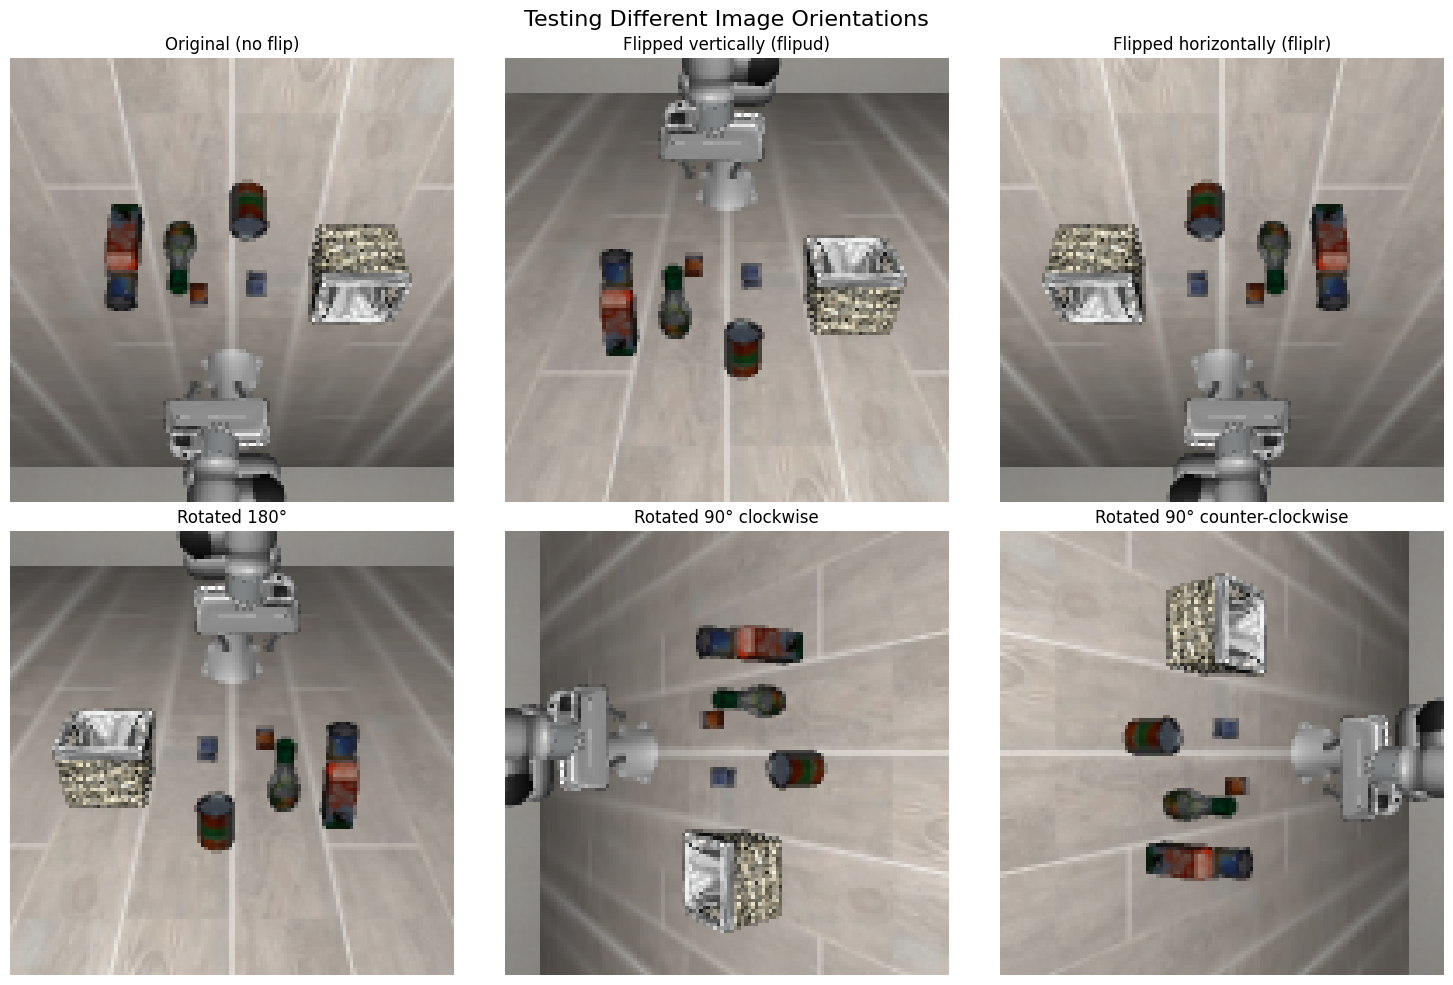

Check which orientation looks correct, then we'll update the visualization code accordingly.


In [10]:
# Test different image orientations to find the correct one
if available and hdf5_files and episode:
    import matplotlib.pyplot as plt

    # Get first image
    image_keys = [key for key in episode['observations'].keys()
                  if 'image' in key.lower() or 'rgb' in key.lower()]

    if image_keys:
        img_key = image_keys[0]
        img_original = episode['observations'][img_key][0]  # First frame

        # Normalize if needed
        if img_original.max() > 1.0:
            img_original = img_original / 255.0

        # Try different transformations
        transformations = {
            'Original (no flip)': img_original,
            'Flipped vertically (flipud)': np.flipud(img_original),
            'Flipped horizontally (fliplr)': np.fliplr(img_original),
            'Rotated 180°': np.rot90(img_original, 2),
            'Rotated 90° clockwise': np.rot90(img_original, -1),
            'Rotated 90° counter-clockwise': np.rot90(img_original, 1),
        }

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Testing Different Image Orientations', fontsize=16)
        axes = axes.flatten()

        for idx, (name, img) in enumerate(transformations.items()):
            axes[idx].imshow(img)
            axes[idx].set_title(name)
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

        print("Check which orientation looks correct, then we'll update the visualization code accordingly.")


## Visualize sample data

You can visualize images or plot actions from the loaded episode.


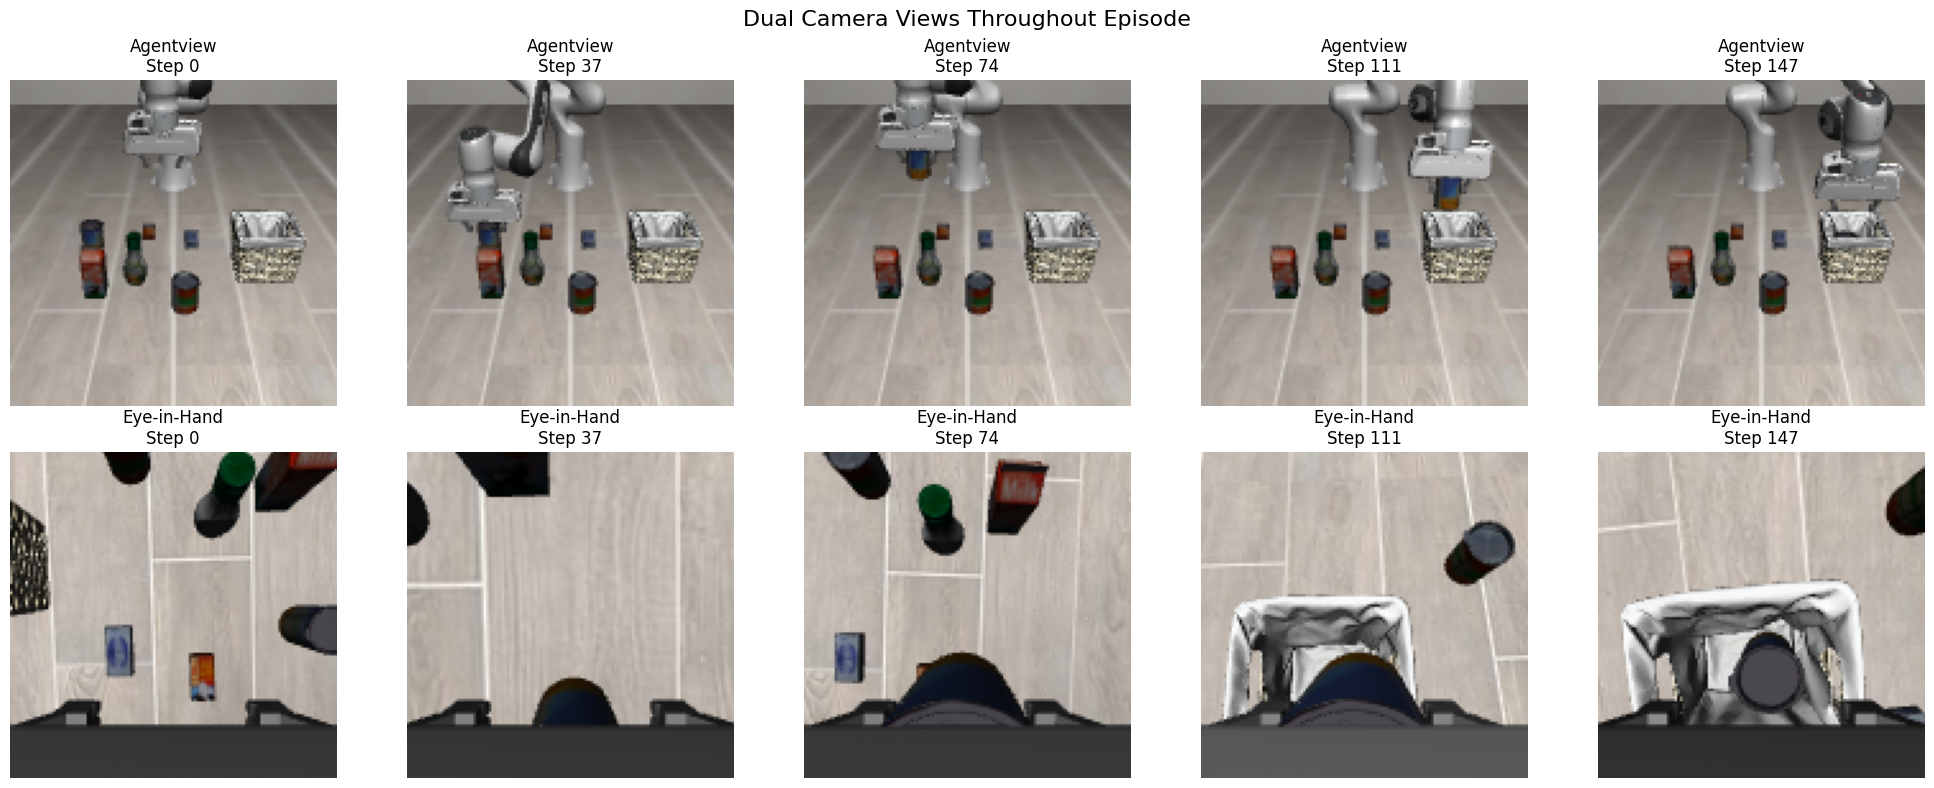

In [11]:
# Display both camera views side-by-side at key moments
if available and hdf5_files and episode:
    agentview_key = None
    eye_in_hand_key = None

    for key in episode['observations'].keys():
        if 'agentview' in key.lower() and 'rgb' in key.lower():
            agentview_key = key
        if 'eye_in_hand' in key.lower() and 'rgb' in key.lower():
            eye_in_hand_key = key

    if agentview_key and eye_in_hand_key:
        # Apply vertical flip to fix image orientation
        agentview = np.array([np.flipud(frame) for frame in episode['observations'][agentview_key]])
        eye_in_hand = np.array([np.flipud(frame) for frame in episode['observations'][eye_in_hand_key]])

        # Normalize if needed
        if agentview.max() > 1.0:
            agentview = agentview / 255.0
        if eye_in_hand.max() > 1.0:
            eye_in_hand = eye_in_hand / 255.0

        # Sample frames
        episode_length = episode['episode_length']
        frame_indices = [0, episode_length//4, episode_length//2,
                        3*episode_length//4, episode_length-1]

        fig, axes = plt.subplots(2, len(frame_indices), figsize=(20, 8))
        fig.suptitle('Dual Camera Views Throughout Episode', fontsize=16, y=0.98)

        for idx, frame_idx in enumerate(frame_indices):
            # Top row: agentview (third-person)
            axes[0, idx].imshow(agentview[frame_idx])
            axes[0, idx].set_title(f'Agentview\nStep {frame_idx}')
            axes[0, idx].axis('off')

            # Bottom row: eye_in_hand (first-person)
            axes[1, idx].imshow(eye_in_hand[frame_idx])
            axes[1, idx].set_title(f'Eye-in-Hand\nStep {frame_idx}')
            axes[1, idx].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Could not find both camera views")


## Create an animation of the episode

Optionally create an animated visualization showing the episode progression.



Animation created with 30 frames (subsampled by 5)
Showing both agentview_rgb (left) and eye_in_hand_rgb (right)


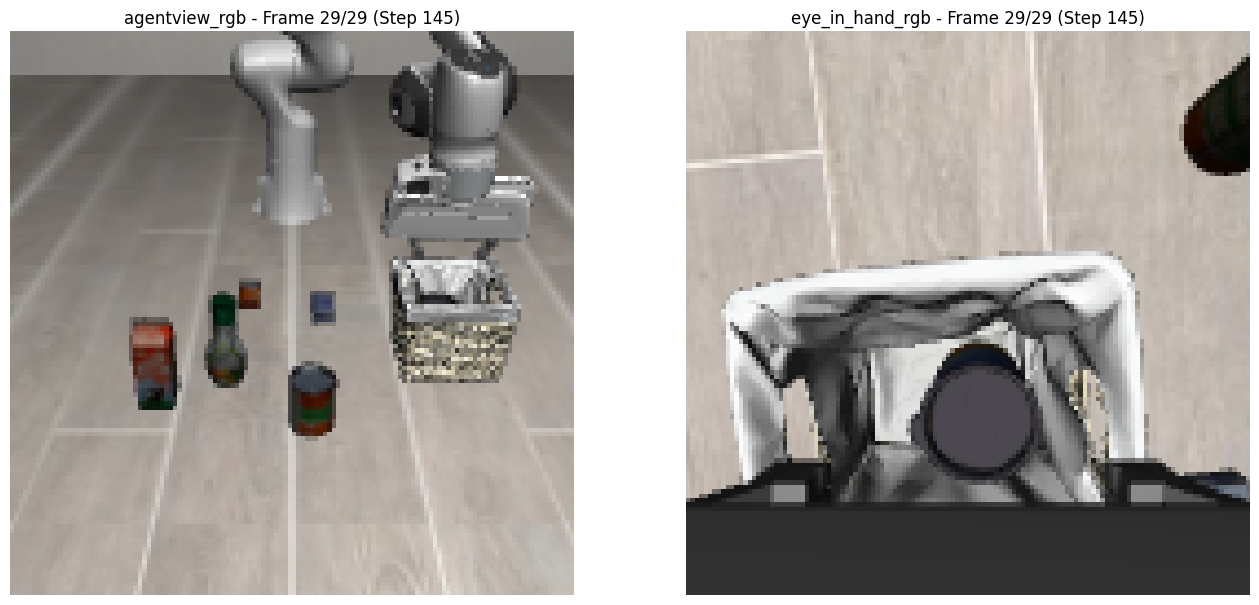

In [12]:
# Create animations for both camera views (optional - can be slow for long episodes)
if available and hdf5_files and episode:
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML, display
    import matplotlib.pyplot as plt

    # Find both camera views
    agentview_key = None
    eye_in_hand_key = None

    for key in episode['observations'].keys():
        if 'agentview' in key.lower() and 'rgb' in key.lower():
            agentview_key = key
        if 'eye_in_hand' in key.lower() and 'rgb' in key.lower():
            eye_in_hand_key = key

    if agentview_key and eye_in_hand_key:
        # Apply vertical flip to fix image orientation
        agentview_seq = np.array([np.flipud(frame) for frame in episode['observations'][agentview_key]])
        eye_in_hand_seq = np.array([np.flipud(frame) for frame in episode['observations'][eye_in_hand_key]])

        # Normalize
        if agentview_seq.max() > 1.0:
            agentview_seq = agentview_seq / 255.0
        if eye_in_hand_seq.max() > 1.0:
            eye_in_hand_seq = eye_in_hand_seq / 255.0

        # Subsample for faster animation (every 5th frame)
        subsample = 5
        agentview_subset = agentview_seq[::subsample]
        eye_in_hand_subset = eye_in_hand_seq[::subsample]

        # Create side-by-side animation
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.axis('off')
        ax2.axis('off')

        im1 = ax1.imshow(agentview_subset[0])
        title1 = ax1.set_title(f'{agentview_key} - Frame 0/{len(agentview_subset)-1}')

        im2 = ax2.imshow(eye_in_hand_subset[0])
        title2 = ax2.set_title(f'{eye_in_hand_key} - Frame 0/{len(eye_in_hand_subset)-1}')

        def animate(frame):
            im1.set_array(agentview_subset[frame])
            title1.set_text(f'{agentview_key} - Frame {frame}/{len(agentview_subset)-1} (Step {frame*subsample})')
            im2.set_array(eye_in_hand_subset[frame])
            title2.set_text(f'{eye_in_hand_key} - Frame {frame}/{len(eye_in_hand_subset)-1} (Step {frame*subsample})')
            return [im1, im2, title1, title2]

        # Create animation
        anim = FuncAnimation(fig, animate, frames=len(agentview_subset),
                           interval=100, blit=True, repeat=True)

        # Convert to HTML for display in Jupyter
        try:
            # Try to use HTML5 video format
            html_video = anim.to_jshtml()
            display(HTML(html_video))
        except:
            # Fallback: try to save as HTML
            try:
                from tempfile import NamedTemporaryFile
                import base64

                # Save animation to temporary HTML file
                with NamedTemporaryFile(suffix='.html', delete=False) as tmp:
                    anim.save(tmp.name, writer='html', fps=10)
                    with open(tmp.name, 'r') as f:
                        html_content = f.read()
                    display(HTML(html_content))
            except Exception as e:
                # Last resort: just show the figure and explain
                plt.tight_layout()
                plt.show()
                print(f"Animation created with {len(agentview_subset)} frames (subsampled by {subsample})")
                print(f"Note: Could not display animation automatically. Error: {e}")
                print("You can manually save the animation using: anim.save('animation.gif', writer='pillow')")

        print(f"\nAnimation created with {len(agentview_subset)} frames (subsampled by {subsample})")
        print(f"Showing both {agentview_key} (left) and {eye_in_hand_key} (right)")
    else:
        print("Could not find both camera views for animation")

In [9]:
# Install faiss in the current kernel's environment
# This ensures faiss is installed in the same Python environment as the kernel
import sys
import subprocess

try:
    import faiss
    print(f"faiss already installed in: {sys.executable}")
except ImportError:
    print(f"Installing faiss-cpu in kernel environment: {sys.executable}")

    # First, ensure pip is available (bootstrap if needed)
    try:
        import pip
    except ImportError:
        print("Bootstrapping pip...")
        subprocess.check_call([sys.executable, "-m", "ensurepip", "--upgrade", "--default-pip"])

    # Now install faiss-cpu
    print("Installing faiss-cpu...")
    result = subprocess.run(
        [sys.executable, "-m", "pip", "install", "faiss-cpu"],
        capture_output=True,
        text=True
    )

    if result.returncode != 0:
        print(f"Installation failed. Error output:")
        print(result.stderr)
        raise RuntimeError(f"Failed to install faiss-cpu: {result.stderr}")

    print("faiss-cpu installed successfully!")
    import faiss

print(f"faiss version: {faiss.__version__ if hasattr(faiss, '__version__') else 'unknown'}")


Installing faiss-cpu in kernel environment: /cluster/home/anmari/meta_vlas/.venv/bin/python
Bootstrapping pip...
Looking in links: /scratch/tmp.53714536.anmari/tmpe8i14g0l
Processing /scratch/tmp.53714536.anmari/tmpe8i14g0l/pip-23.2.1-py3-none-any.whl
Installing faiss-cpu...
faiss-cpu installed successfully!
faiss version: 1.13.2


## FAISS Similarity Search with pi0.5 Embeddings

This section creates a FAISS index of all frames from libero_90 dataset using image embeddings from the pi0.5 model, then queries it with the first example from libero_10.


In [2]:
# Import functions from build_faiss_index_incremental.py
import sys
from pathlib import Path

# Add the libero examples directory to path to import from the script
# The script is in examples/libero/, and notebook is in examples/
notebook_dir = Path.cwd()  # Current working directory (should be examples/)
print(f"Notebook directory: {notebook_dir}")
libero_dir = notebook_dir / "examples" / "libero"
if str(libero_dir) not in sys.path:
    sys.path.insert(0, str(libero_dir))

from build_faiss_index_incremental import load_model, extract_image_embedding, extract_text_embedding, clear_jax_cache

# Load pi0.5 model for extracting image embeddings
print("Loading pi0.5 model...")
image_encoder, text_encoder, tokenizer = load_model()
print("Model loaded successfully!")
print(f"Image encoder type: {type(image_encoder)}")


Notebook directory: /cluster/home/anmari/meta_vlas
Loading pi0.5 model...
Loading pi0.5 model...
Loading model weights...


Loading tokenizer...
Model loaded successfully!
Model loaded successfully!
Image encoder type: <class 'flax.nnx.bridge.wrappers.ToNNX'>


## Query FAISS Index with First Task from libero_90

Load the created FAISS index and query it using the first image and task description from the first task in libero_90.


In [3]:
# Load FAISS index and query with first task from libero_90
import pickle
import faiss
import matplotlib.pyplot as plt
from pathlib import Path

# Load the FAISS index if not already loaded
cache_dir = Path.home() / ".cache" / "libero_faiss"
index_path = cache_dir / "libero_90_faiss_index.index"
metadata_path = cache_dir / "libero_90_faiss_metadata.pkl"

if 'index' not in locals() or index is None:
    if index_path.exists() and metadata_path.exists():
        print("Loading FAISS index from cache...")
        index_cpu = faiss.read_index(str(index_path))
        with open(metadata_path, "rb") as f:
            metadata = pickle.load(f)
        print(f"Loaded index with {index_cpu.ntotal} embeddings")
        print(f"Loaded metadata for {len(metadata)} entries")

        # Keep index on CPU (using faiss-cpu)
        index = index_cpu
        print("Index is on CPU")
    else:
        print(f"ERROR: Index not found at {index_path}")
        print("Please run the index creation cell first.")
        index = None
        metadata = []
else:
    print("Using already loaded index")
    if 'metadata' not in locals():
        # Load metadata if index was loaded but metadata wasn't
        if metadata_path.exists():
            with open(metadata_path, "rb") as f:
                metadata = pickle.load(f)
            print(f"Loaded metadata for {len(metadata)} entries")
        else:
            print("ERROR: Metadata not found!")
            metadata = []


Loading FAISS index from cache...
Loaded index with 669043 embeddings
Loaded metadata for 669043 entries
Index is on CPU


In [4]:
# Get first image and task description from first task in libero_90
if index is not None:
    print("\n" + "="*60)
    print("Loading first task from libero_90...")
    print("="*60)

    libero_90_path = Path(DATASET_DIR) / "libero_90"
    hdf5_files_90 = sorted(list(libero_90_path.glob("*.hdf5")))

    if not hdf5_files_90:
        print("ERROR: No libero_90 HDF5 files found!")
        query_from_90 = None
    else:
        first_file = hdf5_files_90[0]
        print(f"First file: {first_file.name}")

        with h5py.File(first_file, "r") as f:
            # Get task description
            problem_info = json.loads(f["data"].attrs.get("problem_info", "{}"))
            language_instruction = "".join(problem_info.get("language_instruction", []))
            print(f"\nTask description: {language_instruction}")

            # Get first episode
            demos = sorted([k for k in f["data"].keys() if k.startswith("demo_")])
            if demos:
                inds = np.argsort([int(elem[5:]) for elem in demos])
                demos = [demos[i] for i in inds]

            if demos:
                first_demo_key = demos[0]
                demo_data = f["data"][first_demo_key]

                # Get first image from agentview_rgb
                camera_view = "agentview_rgb"
                if "obs" in demo_data and camera_view in demo_data["obs"]:
                    images = np.array(demo_data["obs"][camera_view])
                    first_image = images[0]  # First frame of first episode

                    # Ensure image is in [0, 255] range
                    if first_image.max() <= 1.0:
                        first_image = (first_image * 255).astype(np.uint8)
                    else:
                        first_image = first_image.astype(np.uint8)

                    print(f"\nFirst image shape: {first_image.shape}")
                    print(f"First image dtype: {first_image.dtype}")
                    print(f"First image range: [{first_image.min()}, {first_image.max()}]")

                    query_from_90 = {
                        "image": first_image,
                        "task_description": language_instruction,
                        "file_name": first_file.name,
                        "episode_idx": 0,
                        "demo_key": first_demo_key,
                        "step_idx": 0,
                        "camera_view": camera_view
                    }
                else:
                    print(f"ERROR: {camera_view} not found in observations!")
                    query_from_90 = None
            else:
                print("ERROR: No demos found in file!")
                query_from_90 = None
else:
    print("ERROR: FAISS index not available!")
    query_from_90 = None



Loading first task from libero_90...
First file: KITCHEN_SCENE10_close_the_top_drawer_of_the_cabinet_and_put_the_black_bowl_on_top_of_it_demo.hdf5

Task description: close the top drawer of the cabinet and put the black bowl on top of it

First image shape: (128, 128, 3)
First image dtype: uint8
First image range: [0, 255]


In [5]:
# Extract embedding from the query image and query the FAISS index
# NOTE: The index was built with concatenated image + text embeddings, so we need to do the same
if index is not None and query_from_90 is not None:
    print("\n" + "="*60)
    print("Extracting embedding and querying FAISS index...")
    print("="*60)


    # Extract image embedding
    query_image = query_from_90["image"]
    query_img_embedding = extract_image_embedding(query_image, image_encoder)
    print(f"Image embedding shape: {query_img_embedding.shape}")

    # Extract text embedding from task description
    task_description = query_from_90["task_description"]
    if task_description:
        query_text_embedding = extract_text_embedding(task_description, tokenizer, text_encoder)
        print(f"Text embedding shape: {query_text_embedding.shape}")

        # Concatenate image and text embeddings (same as how index was built)
        query_embedding = np.concatenate([query_img_embedding, query_text_embedding])
        print(f"Concatenated embedding shape: {query_embedding.shape}")
    else:
        print("Warning: No task description found, using image embedding only")
        query_embedding = query_img_embedding

    # Normalize for cosine similarity
    query_embedding = query_embedding.astype(np.float32)
    query_embedding = query_embedding / np.linalg.norm(query_embedding)
    print(f"Query embedding normalized")

    # Query the index
    k = 10  # Number of nearest neighbors
    query_emb_reshaped = query_embedding.reshape(1, -1)  # Add batch dimension

    print(f"Final query embedding shape: {query_emb_reshaped.shape}")

    print(f"\nSearching for top {k} similar frames...")
    distances, indices = index.search(query_emb_reshaped, k)

    # Display results
    print(f"\n{'='*60}")
    print(f"Top {k} Similar Frames Retrieved:")
    print(f"{'='*60}")
    print(f"Query: {query_from_90['file_name']} | Episode 0 | Step 0 | {query_from_90['camera_view']}")
    print(f"Task: {query_from_90['task_description']}")
    print(f"\n{'Rank':<6} {'Distance':<12} {'File':<50} {'Episode':<8} {'Step':<6} {'Camera':<15}")
    print("-" * 100)

    results_90 = []
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
        meta = metadata[idx]
        results_90.append({
            'rank': i + 1,
            'distance': dist,
            'metadata': meta
        })
        print(f"{i+1:<6} {dist:<12.4f} {meta['file_name']:<50} {meta['episode_idx']:<8} {meta['step_idx']:<6} {meta['camera_view']:<15}")

    print(f"\n{'='*60}")
    print("Query completed!")
    print(f"{'='*60}")
else:
    print("ERROR: Cannot query - index or query data not available!")
    results_90 = None



Extracting embedding and querying FAISS index...
Image embedding shape: (2048,)
Text embedding shape: (2048,)
Concatenated embedding shape: (4096,)
Query embedding normalized
Final query embedding shape: (1, 4096)

Searching for top 10 similar frames...

Top 10 Similar Frames Retrieved:
Query: KITCHEN_SCENE10_close_the_top_drawer_of_the_cabinet_and_put_the_black_bowl_on_top_of_it_demo.hdf5 | Episode 0 | Step 0 | agentview_rgb
Task: close the top drawer of the cabinet and put the black bowl on top of it

Rank   Distance     File                                               Episode  Step   Camera         
----------------------------------------------------------------------------------------------------
1      1.0000       KITCHEN_SCENE10_close_the_top_drawer_of_the_cabinet_and_put_the_black_bowl_on_top_of_it_demo.hdf5 0        0      agentview_rgb  
2      1.0000       KITCHEN_SCENE10_close_the_top_drawer_of_the_cabinet_and_put_the_black_bowl_on_top_of_it_demo.hdf5 0        1      ag


Visualizing Query Results


/scratch/tmp.53761752.anmari/ipykernel_1371052/2342693756.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


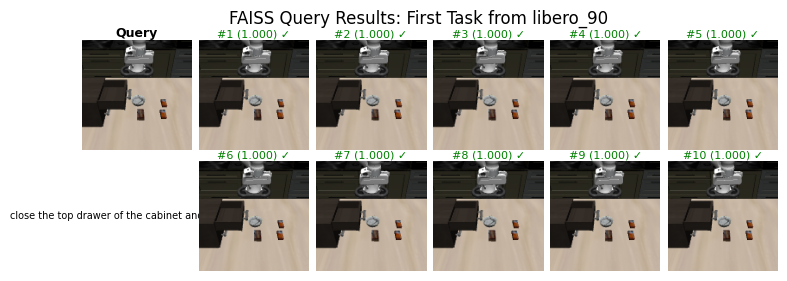


Displayed query image and top 10 similar images from libero_90

Analysis:
  - Query was from: KITCHEN_SCENE10_close_the_top_drawer_of_the_cabinet_and_put_the_black_bowl_on_top_of_it_demo.hdf5
  - Retrieved 10 similar frames
  - Distance range: [1.0000, 0.9999]
  - Results from same file: 10/10
  - Results from same episode: 10/10


In [ ]:
# Visualize query results - arranged in 2 rows with minimal whitespace
if results_90 is not None and query_from_90 is not None:
    print("\n" + "="*60)
    print("Visualizing Query Results")
    print("="*60)

    # Load top-k similar images
    top_k = min(10, len(results_90))  # Show top 10
    similar_images = []
    similar_meta = []

    libero_90_path = Path(DATASET_DIR) / "libero_90"

    for result in results_90[:top_k]:
        meta = result['metadata']
        file_path = libero_90_path / meta['file_name']

        with h5py.File(file_path, "r") as f:
            demo_data = f["data"][meta['demo_key']]
            image = np.array(demo_data["obs"][meta['camera_view']][meta['step_idx']])

            # Normalize if needed
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            image = image / 255.0  # Convert to [0, 1] for display

            similar_images.append(image)
            similar_meta.append({
                'meta': meta,
                'distance': result['distance']
            })

    # Prepare query image for display
    query_img_display = query_from_90["image"].copy()
    if query_img_display.max() > 1.0:
        query_img_display = query_img_display / 255.0

    # Arrange in 2 rows: 5 images per row
    # Row 0: Query + results 0-4 (5 results)
    # Row 1: Task description + results 5-9 (5 results)
    num_cols = 6  # Query/task column + 5 result columns

    # Create visualization with 2 rows, minimal whitespace
    fig, axes = plt.subplots(2, num_cols, figsize=(num_cols * 1.5, 3),
                            gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
    fig.suptitle(f'FAISS Query Results: First Task from libero_90', fontsize=12, y=0.98)

    # Row 0: Query image + first 5 results (indices 0-4)
    # Show query image in first column
    axes[0, 0].imshow(np.flipud(query_img_display))
    axes[0, 0].set_title('Query', fontsize=9, fontweight='bold', pad=2)
    axes[0, 0].axis('off')

    # Show first 5 results in row 0 (indices 0-4)
    for i in range(min(5, top_k)):
        img = similar_images[i]
        info = similar_meta[i]
        axes[0, i+1].imshow(np.flipud(img))
        axes[0, i+1].set_title(f'#{i+1} ({info["distance"]:.3f})', fontsize=8, pad=2)
        axes[0, i+1].axis('off')

    # Row 1: Task description + next 5 results (indices 5-9)
    # Show task description in first column
    task_text = query_from_90['task_description'][:50] + "..." if len(query_from_90['task_description']) > 50 else query_from_90['task_description']
    axes[1, 0].text(0.5, 0.5, task_text, ha='center', va='center',
                    fontsize=7, transform=axes[1, 0].transAxes, wrap=True)
    axes[1, 0].axis('off')

    # Show next 5 results in row 1 (indices 5-9)
    for i in range(5, min(10, top_k)):
        img = similar_images[i]
        info = similar_meta[i]
        col_idx = i - 5 + 1  # Column index: 1, 2, 3, 4, 5
        axes[1, col_idx].imshow(np.flipud(img))
        axes[1, col_idx].set_title(f'#{i+1} ({info["distance"]:.3f})', fontsize=8, pad=2)
        axes[1, col_idx].axis('off')

    # Hide unused subplots if top_k < 10
    if top_k < 10:
        for i in range(top_k + 1, num_cols):
            axes[0, i].axis('off')
            axes[1, i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    print(f"\nDisplayed query image and top {top_k} similar images from libero_90")
    print(f"\nAnalysis:")
    print(f"  - Query was from: {query_from_90['file_name']}")
    print(f"  - Retrieved {len(results_90)} similar frames")
    print(f"  - Distance range: [{results_90[0]['distance']:.4f}, {results_90[-1]['distance']:.4f}]")

    # Check if any results are from the same file/episode
    same_file_count = sum(1 for r in results_90 if r['metadata']['file_name'] == query_from_90['file_name'])
    same_episode_count = sum(1 for r in results_90 if (r['metadata']['file_name'] == query_from_90['file_name'] and
                                                        r['metadata']['episode_idx'] == query_from_90['episode_idx']))
    print(f"  - Results from same file: {same_file_count}/{len(results_90)}")
    print(f"  - Results from same episode: {same_episode_count}/{len(results_90)}")
else:
    print("ERROR: Cannot visualize - results not available!")


## Evaluate Pretrained Model on First Task of libero_90

Evaluate the pretrained model directly (without client/server architecture) on the first task of libero_90.


In [ ]:
# Evaluate pretrained model on first task of libero_90
import collections
import logging
import math
import pathlib
import imageio
import torch

sys.path.append("third_party/libero")
from libero.libero import benchmark
from libero.libero import get_libero_path
from libero.libero.envs import OffScreenRenderEnv
from openpi_client import image_tools
from openpi.policies import policy_config as _policy_config
from openpi.training import config as _config
import tqdm

# To fix versioning issues with torch
torch.serialization.add_safe_globals(
    [
        np.core.multiarray._reconstruct,  # noqa
        np.ndarray,
        np.dtype,
        np.dtypes.Float64DType,
    ]
)

# Configuration
TASK_SUITE_NAME = "libero_90"
TASK_ID = 0  # First task
NUM_TRIALS = 50
RESIZE_SIZE = 224
REPLAN_STEPS = 5
NUM_STEPS_WAIT = 10
SEED = 7
VIDEO_OUT_PATH = "data/libero/videos"
CHECKPOINT_CONFIG = "pi05_libero"
CHECKPOINT_DIR = "gs://openpi-assets/checkpoints/pi05_libero"

LIBERO_DUMMY_ACTION = [0.0] * 6 + [-1.0]
LIBERO_ENV_RESOLUTION = 256

def _quat2axisangle(quat):
    """Convert quaternion to axis-angle representation."""
    if quat[3] > 1.0:
        quat[3] = 1.0
    elif quat[3] < -1.0:
        quat[3] = -1.0
    den = np.sqrt(1.0 - quat[3] * quat[3])
    if math.isclose(den, 0.0):
        return np.zeros(3)
    return (quat[:3] * 2.0 * math.acos(quat[3])) / den

def _get_libero_env(task, resolution, seed):
    """Initialize LIBERO environment."""
    task_description = task.language
    task_bddl_file = pathlib.Path(get_libero_path("bddl_files")) / task.problem_folder / task.bddl_file
    env_args = {"bddl_file_name": task_bddl_file, "camera_heights": resolution, "camera_widths": resolution}
    env = OffScreenRenderEnv(**env_args)
    env.seed(seed)
    return env, task_description

# Set random seed
np.random.seed(SEED)

# Load the policy
print("Loading policy from checkpoint...")
train_config = _config.get_config(CHECKPOINT_CONFIG)
policy = _policy_config.create_trained_policy(train_config, CHECKPOINT_DIR)
print("Policy loaded successfully!")

# Initialize LIBERO task suite
benchmark_dict = benchmark.get_benchmark_dict()
task_suite = benchmark_dict[TASK_SUITE_NAME]()
num_tasks_in_suite = task_suite.n_tasks

if TASK_ID >= num_tasks_in_suite:
    raise ValueError(f"Task ID {TASK_ID} is out of range. Task suite has {num_tasks_in_suite} tasks.")

print(f"Task suite: {TASK_SUITE_NAME}")
print(f"Evaluating task {TASK_ID} of {num_tasks_in_suite}")

# Determine max steps
if TASK_SUITE_NAME == "libero_90":
    max_steps = 400
else:
    max_steps = 300  # default

pathlib.Path(VIDEO_OUT_PATH).mkdir(parents=True, exist_ok=True)

# Get task
task = task_suite.get_task(TASK_ID)
initial_states = task_suite.get_task_init_states(TASK_ID)

# Initialize environment
env, task_description = _get_libero_env(task, LIBERO_ENV_RESOLUTION, SEED)
print(f"Task: {task_description}")

# Start evaluation
task_episodes, task_successes = 0, 0
print(f"\nStarting evaluation: {NUM_TRIALS} trials...")


Loading policy from checkpoint...


/cluster/home/anmari/meta_vlas/.venv/lib/python3.11/site-packages/jax/extend/linear_util.py:38: DeprecationWarning: linear_util.wrap_init is missing a DebugInfo object. This behavior is deprecated, use api_util.debug_info() to construct a proper DebugInfo object and propagate it to this function. See https://github.com/jax-ml/jax/issues/26480 for more details.
  debug_info = debug_info or _missing_debug_info("linear_util.wrap_init")
/cluster/home/anmari/meta_vlas/.venv/lib/python3.11/site-packages/jax/extend/linear_util.py:38: DeprecationWarning: linear_util.wrap_init is missing a DebugInfo object. This behavior is deprecated, use api_util.debug_info() to construct a proper DebugInfo object and propagate it to this function. See https://github.com/jax-ml/jax/issues/26480 for more details.
  debug_info = debug_info or _missing_debug_info("linear_util.wrap_init")
/cluster/home/anmari/meta_vlas/.venv/lib/python3.11/site-packages/flax/core/scope.py:959: DeprecationWarning: shape requires n

Policy loaded successfully!
Task suite: libero_90
Evaluating task 0 of 90
[Warning]: datasets path /cluster/home/anmari/meta_vlas/third_party/libero/libero/libero/../datasets does not exist!
[Warning]: datasets path /cluster/home/anmari/meta_vlas/third_party/libero/libero/libero/../datasets does not exist!
Task: close the top drawer of the cabinet

Starting evaluation: 50 trials...


In [ ]:
# Run evaluation episodes
NUM_TRIALS = 10
for episode_idx in tqdm.tqdm(range(NUM_TRIALS), desc=f"Task {TASK_ID}"):
    print(f"Episode {episode_idx+1} of {NUM_TRIALS}")
    # Reset environment
    env.reset()
    action_plan = collections.deque()

    # Set initial states
    obs = env.set_init_state(initial_states[episode_idx])

    # Setup
    t = 0
    replay_images = []

    while t < max_steps + NUM_STEPS_WAIT:
        try:
            # Wait for objects to stabilize
            if t < NUM_STEPS_WAIT:
                obs, reward, done, info = env.step(LIBERO_DUMMY_ACTION)
                t += 1
                continue

            # Get preprocessed images (rotate 180 degrees to match train preprocessing)
            img = np.ascontiguousarray(obs["agentview_image"][::-1, ::-1])
            wrist_img = np.ascontiguousarray(obs["robot0_eye_in_hand_image"][::-1, ::-1])
            img = image_tools.convert_to_uint8(
                image_tools.resize_with_pad(img, RESIZE_SIZE, RESIZE_SIZE)
            )
            wrist_img = image_tools.convert_to_uint8(
                image_tools.resize_with_pad(wrist_img, RESIZE_SIZE, RESIZE_SIZE)
            )

            # Save for replay video
            replay_images.append(img)

            if not action_plan:
                # Prepare observations dict
                element = {
                    "observation/image": img,
                    "observation/wrist_image": wrist_img,
                    "observation/state": np.concatenate(
                        (
                            obs["robot0_eef_pos"],
                            _quat2axisangle(obs["robot0_eef_quat"]),
                            obs["robot0_gripper_qpos"],
                        )
                    ),
                    "prompt": str(task_description),
                }

                # Query model directly (no websocket)
                result = policy.infer(element)
                action_chunk = result["actions"]
                assert len(action_chunk) >= REPLAN_STEPS, \
                    f"Policy only predicts {len(action_chunk)} steps, need {REPLAN_STEPS}"
                action_plan.extend(action_chunk[:REPLAN_STEPS])

            action = action_plan.popleft()

            # Execute action
            obs, reward, done, info = env.step(action.tolist())
            if done:
                task_successes += 1
                break
            t += 1

        except Exception as e:
            print(f"Error in episode {episode_idx+1}: {e}")
            break

    task_episodes += 1

    # Save replay video
    suffix = "success" if done else "failure"
    task_segment = task_description.replace(" ", "_")
    video_filename = f"rollout_task{TASK_ID}_{task_segment}_ep{episode_idx+1}_{suffix}.mp4"
    imageio.mimwrite(
        pathlib.Path(VIDEO_OUT_PATH) / video_filename,
        [np.asarray(x) for x in replay_images],
        fps=10,
    )

    # Log progress
    if (episode_idx + 1) % 1== 0:
        print(f"  Episodes: {task_episodes}, Successes: {task_successes} ({task_successes/task_episodes*100:.1f}%)")

# Final results
print(f"\n{'='*60}")
print(f"Final Results for Task {TASK_ID}:")
print(f"  Task: {task_description}")
print(f"  Episodes: {task_episodes}")
print(f"  Successes: {task_successes}")
print(f"  Success rate: {task_successes/task_episodes*100:.1f}%")
print(f"{'='*60}")


 ... (more hidden) ...

Episode 1 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 4, Successes: 0 (0.0%)
Episode 2 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 5, Successes: 0 (0.0%)
Episode 3 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 6, Successes: 0 (0.0%)
Episode 4 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 7, Successes: 0 (0.0%)
Episode 5 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 8, Successes: 0 (0.0%)
Episode 6 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 9, Successes: 0 (0.0%)
Episode 7 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 10, Successes: 1 (10.0%)
Episode 8 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 11, Successes: 1 (9.1%)
Episode 9 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 12, Successes: 1 (8.3%)
Episode 10 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 13, Successes: 2 (15.4%)
Episode 11 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 14, Successes: 2 (14.3%)
Episode 12 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 15, Successes: 2 (13.3%)
Episode 13 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 16, Successes: 2 (12.5%)
Episode 14 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 17, Successes: 2 (11.8%)
Episode 15 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 18, Successes: 2 (11.1%)
Episode 16 of 50


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
 ... (more hidden) ...

  Episodes: 19, Successes: 2 (10.5%)
Episode 17 of 50


 ... (more hidden) ...


KeyboardInterrupt: 

In [ ]:
## Fine-tune Model on First Task from libero_90

import h5py
import numpy as np
from pathlib import Path
from typing import Iterator, Tuple
import jax.numpy as jnp

import openpi.models.model as _model
from openpi.shared import image_tools
from openpi.models.model import IMAGE_RESOLUTION
from utils import train_model_on_fly

if "model" not in locals():
    # Load the full model (not just encoders)
    print("Loading full model for fine-tuning...")
    from openpi.training import config as _config
    from openpi.models import model as _model
    import openpi.shared.download as download

    train_config = _config.get_config("pi05_libero")
    checkpoint_dir = download.maybe_download("gs://openpi-assets/checkpoints/pi05_libero")
    model = train_config.model.load(_model.restore_params(checkpoint_dir / "params", dtype=jnp.bfloat16))
    print("Model loaded successfully!")

if "all_episodes" not in locals():
    # Load first task from libero_90
    DATASET_DIR = "/cluster/scratch/anmari/libero_datasets"
    libero_90_path = Path(DATASET_DIR) / "libero_90"
    hdf5_files = sorted(list(libero_90_path.glob("*.hdf5")))

    if not hdf5_files:
        raise ValueError("No HDF5 files found in libero_90!")

    first_task_file = hdf5_files[0]
    print(f"\nFine-tuning on first task: {first_task_file.name}")

    # Load all episodes from the first task
    def load_all_episodes(hdf5_path):
        """Load all episodes from an HDF5 file."""
        episodes = []
        with h5py.File(hdf5_path, "r") as f:
            demo_keys = [key for key in f["data"].keys() if key.startswith("demo_")]
            for demo_key in demo_keys:
                demo_data = f["data"][demo_key]
                episode = {
                    'observations': {},
                    'actions': np.array(demo_data['actions']),
                }
                # Load all camera views
                for camera_view in ['agentview_rgb', 'eye_in_hand_rgb']:
                    if camera_view in demo_data['obs']:
                        episode['observations'][camera_view] = np.array(demo_data['obs'][camera_view])
                episodes.append(episode)
        return episodes

    all_episodes = load_all_episodes(first_task_file)
    print(f"Loaded {len(all_episodes)} episodes from first task")

# Convert LIBERO data to model format
def convert_to_model_format(episodes, batch_size=64):
    """
    Convert LIBERO episodes to model's Observation and Actions format.
    Returns an iterator of (observation, actions) tuples.
    """
    # Flatten all episodes into a sequence of (obs, action) pairs
    all_obs = []
    all_actions = []

    for episode in episodes:
        # Get the length from actions (should match observations)
        episode_len = len(episode['actions'])

        # Process each timestep
        for t in range(episode_len):
            # Prepare observation dict with images
            obs_dict = {}
            for camera_view, images in episode['observations'].items():
                # Get image at timestep t
                img = images[t]  # Shape: (H, W, 3)

                # Normalize to [0, 255] if needed
                if img.max() <= 1.0:
                    img = (img * 255).astype(np.uint8)
                else:
                    img = img.astype(np.uint8)

                # Resize to model's expected size (224, 224)
                img_resized = image_tools.resize_with_pad(img, IMAGE_RESOLUTION[0], IMAGE_RESOLUTION[1])

                # Convert to float32 and normalize to [-1, 1]
                img_normalized = img_resized.astype(jnp.float32) / 255.0 * 2.0 - 1.0

                obs_dict[camera_view] = img_normalized

            # Get action at timestep t
            action = episode['actions'][t]  # Shape: (7,)

            all_obs.append(obs_dict)
            all_actions.append(action)

    # Create batches
    num_samples = len(all_obs)
    print(f"Total samples: {num_samples}")

    for i in range(0, num_samples, batch_size):
        batch_end = min(i + batch_size, num_samples)
        batch_obs = all_obs[i:batch_end]
        batch_actions = np.array(all_actions[i:batch_end])

        # Stack observations into batch format
        # Map LIBERO camera views to model's expected camera view names
        # Model expects: "base_0_rgb", "left_wrist_0_rgb", "right_wrist_0_rgb"
        # LIBERO provides: "agentview_rgb", "eye_in_hand_rgb"
        obs_batch = {}
        obs_masks = {}

        # Map agentview_rgb -> base_0_rgb (overhead/base camera)
        if 'agentview_rgb' in batch_obs[0]:
            images = jnp.stack([obs['agentview_rgb'] for obs in batch_obs])
            obs_batch['base_0_rgb'] = images
            obs_masks['base_0_rgb'] = jnp.ones(len(batch_obs), dtype=jnp.bool_)

        # Map eye_in_hand_rgb -> left_wrist_0_rgb (wrist camera)
        if 'eye_in_hand_rgb' in batch_obs[0]:
            images = jnp.stack([obs['eye_in_hand_rgb'] for obs in batch_obs])
            obs_batch['left_wrist_0_rgb'] = images
            obs_masks['left_wrist_0_rgb'] = jnp.ones(len(batch_obs), dtype=jnp.bool_)
            # Also use the same image for right_wrist_0_rgb (model expects 3 cameras)
            obs_batch['right_wrist_0_rgb'] = images  # Duplicate for right wrist
            obs_masks['right_wrist_0_rgb'] = jnp.ones(len(batch_obs), dtype=jnp.bool_)

        # Get state (robot proprioception) - use zeros if not available
        # LIBERO doesn't provide state, so we'll use zeros
        # Model expects state with shape (batch, action_dim) where action_dim=32
        batch_size_actual = len(batch_obs)
        model_action_dim = 32  # Model expects state_dim = action_dim = 32
        state = jnp.zeros((batch_size_actual, model_action_dim), dtype=jnp.float32)

        # Create Observation object
        observation = _model.Observation(
            images=obs_batch,
            image_masks=obs_masks,
            state=state,
            tokenized_prompt=None,
            tokenized_prompt_mask=None,
        )

        # Create Actions object
        # Actions is a type alias for Float[ArrayT, "*b ah ad"]
        # Shape should be (batch, action_horizon, action_dim)
        # LIBERO actions are (7,) per timestep, but model expects action_dim=32
        action_horizon = 10  # From pi05_libero config
        libero_action_dim = 7  # LIBERO action dimension
        model_action_dim = 32  # Model expects action_dim=32 (from pi05_libero config default)

        # Expand single timestep actions to action_horizon
        # Repeat the action for action_horizon timesteps
        batch_size_actual = len(batch_actions)
        actions_expanded = jnp.repeat(
            batch_actions[:, None, :],  # (batch, 1, libero_action_dim=7)
            action_horizon,  # Repeat 10 times
            axis=1  # Along the action_horizon dimension
        )  # Shape: (batch, action_horizon, libero_action_dim=7)

        # Pad actions from 7 to 32 dimensions (model expects action_dim=32)
        # Pad with zeros for the extra dimensions
        padding_size = model_action_dim - libero_action_dim
        actions_padded = jnp.pad(
            actions_expanded,
            pad_width=((0, 0), (0, 0), (0, padding_size)),  # Pad last dimension
            mode='constant',
            constant_values=0.0
        )  # Shape: (batch, action_horizon, model_action_dim=32)

        # Actions is just a JAX array, not a class
        actions = jnp.array(actions_padded, dtype=jnp.float32)

        yield observation, actions

# Create training iterator - keep it lazy to avoid loading all batches into GPU memory
# Don't convert to list - keep as generator to create batches on-demand
def make_training_iterator():
    """Returns a new iterator over training batches. Creates batches on-demand."""
    while True:  # Infinite loop to restart when exhausted
        for batch in convert_to_model_format(all_episodes, batch_size=64):
            yield batch

training_iterator = make_training_iterator()

# Count batches for info (this will consume the iterator once, but that's ok for counting)
print("Counting training batches...")
batch_count = sum(1 for _ in convert_to_model_format(all_episodes, batch_size=64))
print(f"Total training batches: {batch_count}\n")

# Fine-tune the model
print("\nStarting fine-tuning...")
print("Training hyperparameters:")
print(f"  Learning rate: 2.5e-5")
print(f"  Number of steps: 500")
print(f"  Batch size: 64")
print(f"  Warmup steps: 50")

trained_model = train_model_on_fly(
    model=model,
    training_set=training_iterator,
    learning_rate=2.5e-5,
    num_steps=500,  # Adjust based on your needs
    batch_size=64,
    warmup_steps=50,
    weight_decay=0.0,
    log_interval=50,
    seed=42,
)

print("\nFine-tuning completed!")
print(f"Trained model type: {type(trained_model)}")

Loading full model for fine-tuning...


Model loaded successfully!

Fine-tuning on first task: KITCHEN_SCENE10_close_the_top_drawer_of_the_cabinet_and_put_the_black_bowl_on_top_of_it_demo.hdf5
Loaded 50 episodes from first task
Counting training batches...
Total samples: 10662
Total training batches: 167


Starting fine-tuning...
Training hyperparameters:
  Learning rate: 2.5e-5
  Number of steps: 500
  Batch size: 64
  Warmup steps: 50


Training:   0%|                                                               | 0/500 [00:00<?, ?it/s]

Compiling training step (this may take a few minutes)...
Total samples: 10662


2026-01-11 00:41:35.108844: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1092] Compiling 2486 configs for 82 fusions on a single thread.


In [ ]:
# Run evaluation episodes
NUM_TRIALS = 10

for episode_idx in tqdm.tqdm(range(NUM_TRIALS), desc=f"Task {TASK_ID}"):
    print(f"Episode {episode_idx+1} of {NUM_TRIALS}")
    # Reset environment
    env.reset()
    action_plan = collections.deque()

    # Set initial states
    obs = env.set_init_state(initial_states[episode_idx])

    # Setup
    t = 0
    replay_images = []

    while t < max_steps + NUM_STEPS_WAIT:
        try:
            # Wait for objects to stabilize
            if t < NUM_STEPS_WAIT:
                obs, reward, done, info = env.step(LIBERO_DUMMY_ACTION)
                t += 1
                continue

            # Get preprocessed images (rotate 180 degrees to match train preprocessing)
            img = np.ascontiguousarray(obs["agentview_image"][::-1, ::-1])
            wrist_img = np.ascontiguousarray(obs["robot0_eye_in_hand_image"][::-1, ::-1])
            img = image_tools.convert_to_uint8(
                image_tools.resize_with_pad(img, RESIZE_SIZE, RESIZE_SIZE)
            )
            wrist_img = image_tools.convert_to_uint8(
                image_tools.resize_with_pad(wrist_img, RESIZE_SIZE, RESIZE_SIZE)
            )

            # Save for replay video
            replay_images.append(img)

            if not action_plan:
                # Prepare observations dict
                element = {
                    "observation/image": img,
                    "observation/wrist_image": wrist_img,
                    "observation/state": np.concatenate(
                        (
                            obs["robot0_eef_pos"],
                            _quat2axisangle(obs["robot0_eef_quat"]),
                            obs["robot0_gripper_qpos"],
                        )
                    ),
                    "prompt": str(task_description),
                }

                # Query model directly (no websocket)
                result = policy.infer(element)
                action_chunk = result["actions"]
                assert len(action_chunk) >= REPLAN_STEPS, \
                    f"Policy only predicts {len(action_chunk)} steps, need {REPLAN_STEPS}"
                action_plan.extend(action_chunk[:REPLAN_STEPS])

            action = action_plan.popleft()

            # Execute action
            obs, reward, done, info = env.step(action.tolist())
            if done:
                task_successes += 1
                break
            t += 1

        except Exception as e:
            print(f"Error in episode {episode_idx+1}: {e}")
            break

    task_episodes += 1

    # Save replay video
    suffix = "success" if done else "failure"
    task_segment = task_description.replace(" ", "_")
    video_filename = f"rollout_task{TASK_ID}_{task_segment}_ep{episode_idx+1}_{suffix}.mp4"
    imageio.mimwrite(
        pathlib.Path(VIDEO_OUT_PATH) / video_filename,
        [np.asarray(x) for x in replay_images],
        fps=10,
    )

    # Log progress
    if (episode_idx + 1) % 1== 0:
        print(f"  Episodes: {task_episodes}, Successes: {task_successes} ({task_successes/task_episodes*100:.1f}%)")

# Final results
print(f"\n{'='*60}")
print(f"Final Results for Task {TASK_ID}:")
print(f"  Task: {task_description}")
print(f"  Episodes: {task_episodes}")
print(f"  Successes: {task_successes}")
print(f"  Success rate: {task_successes/task_episodes*100:.1f}%")
print(f"{'='*60}")
